<a href="https://colab.research.google.com/github/sarahmfrost/compostnet/blob/bryan/compostnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CompostNet binary classifier
This is a model from compostnet, but with only to classes that are defined as:
- `trash`: trash and glass.
- `recyclable`: cardboard, metal, paper and plastic.

## Necessary libraries
 - jupyter notebook: `pip install jupyter`
 - tensorflow: `pip install tensorflow`
 - matplotlib: `pip install matplotlib`
 - keras: `pip install keras`

## Necessary imports

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.python import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, ZeroPadding2D
from keras.layers.merge import concatenate
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.callbacks import CSVLogger
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
import pandas as pd

## Define paths for training, testing and where to save files

 Set `IS_ALREADY_TRAINED` to True if the model is already trained and saved in this folder. If you don't have the file or you just want to train again, set it as False.

In [2]:
# Paths of images for train and test
TRAINING_DATA_DIR  = 'compostnet-dataset-resized/training/'
TEST_DATA_DIR = 'compostnet-dataset-resized/test/'

# Names of the model object file and history log file
MODEL_FILE = 'model_object'
TRAINING_LOGS_FILE = 'training_csv.log'

# Flag to know if the previous files already exist in the current folder
IS_ALREADY_TRAINED = True

## Hyperparams

In [3]:
IMAGE_WIDTH, IMAGE_HEIGHT = 400, 300
EPOCHS = 20
BATCH_SIZE = 8

## Load the data
Create an instance for train, validation and test.

In [4]:
# Data augmentation
training_data_generator = ImageDataGenerator(
  rescale = 1./255,
  validation_split=0.3
)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [5]:
# Data Preparation
training_generator = training_data_generator.flow_from_directory(
  TRAINING_DATA_DIR,
  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
  batch_size = BATCH_SIZE,
  class_mode='categorical',
  subset='training')
validation_generator = training_data_generator.flow_from_directory(
  TRAINING_DATA_DIR,
  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
  batch_size = BATCH_SIZE,
  class_mode='categorical',
  subset='validation')
test_generator = test_data_generator.flow_from_directory(
  TEST_DATA_DIR,
  target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
  color_mode="rgb",
  batch_size = 1,
  class_mode="categorical",
  shuffle=True)

Found 1417 images belonging to 2 classes.
Found 606 images belonging to 2 classes.
Found 504 images belonging to 2 classes.


## The Model

In [6]:
def build_2convolutional_layer_model(width, height, layers):
  """ Builds a x3 CNN and add details later
      https://machinelearningmastery.com/keras-functional-api-deep-learning/
  """
  
  input = Input(shape=(width, height, layers))
  
  # first feature extractor
  conv1 = Conv2D(32, kernel_size=3, activation='relu')(input)
  conv2 = Conv2D(32, kernel_size=3, activation='relu')(conv1)
  pool1 = MaxPooling2D(pool_size=(2,2))(conv2)
  
  conv3 = Conv2D(64, 3, 3, activation='relu')(pool1)
  conv4 = Conv2D(64, 3, 3, activation='relu')(conv3)
  pool2 = MaxPooling2D(pool_size=(2,2))(conv4)
  
  conv5 = Conv2D(128, 3, 3, activation='relu')(pool2)
  conv6 = Conv2D(128, 3, 3, activation='relu')(conv3)
  pool3 = MaxPooling2D(pool_size=(2,2))(conv6)
  
  conv7 = Conv2D(256, 3, 3, activation='relu')(pool3)
  conv8 = Conv2D(256, 3, 3, activation='relu')(conv3)
  pool4 = MaxPooling2D(pool_size=(2,2))(conv8)
  
  flat = Flatten()(pool4)
  hidden1 = Dense(256, activation='relu')(flat)
  drop1 = Dropout(0.5)(hidden1)
  
  hidden2= Dense(256, activation='relu')(drop1)
  drop2 = Dropout(0.5)(hidden2)
  
  
  # prediction output
  output = Dense(1, activation='sigmoid')(drop2)
  
  model = Model(inputs=input, outputs=output)
  return model

## Training
If the model is trained and saved, you don't need to train it again.

In [7]:
if IS_ALREADY_TRAINED:
    model = load_model(MODEL_FILE)
else:
    model = build_2convolutional_layer_model(IMAGE_WIDTH, IMAGE_HEIGHT, 3)

    model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),metrics=['categorical_accuracy'])
    
    csv_logger = CSVLogger(TRAINING_LOGS_FILE, separator=',', append=False)
    
    history = model.fit(
          training_generator,
          steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=validation_generator,
          validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
          verbose=1,
          callbacks=[csv_logger] # to store the history
    )
    
    model.save(MODEL_FILE)

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 398, 298, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 396, 296, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 198, 148, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 49, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 16, 256)       147712    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 8, 256)       

# Testing

In [9]:
label_map = (test_generator.class_indices)
label_map

{'class_recyclable': 0, 'class_trash': 1}

In [10]:
STEP_SIZE_TEST = test_generator.n
probabilities = model.predict(test_generator, steps=STEP_SIZE_TEST)

print(probabilities[:3])

[[0.5064828]
 [0.5132284]
 [0.5058777]]


In [11]:
filenames = test_generator.filenames
nb_samples = len(filenames)
nb_samples

504

## Evaluate to see the accuracy

In [12]:
metrics = model.evaluate(test_generator, steps=STEP_SIZE_TEST)
print(model.metrics_names)
print(metrics)

504/504 [==============================] - 11s 21ms/step - loss: 1.1921e-07 - categorical_accuracy: 0.7480
['loss', 'categorical_accuracy']
[1.1920928955078125e-07, 0.7480158805847168]


## Plot model accuracy

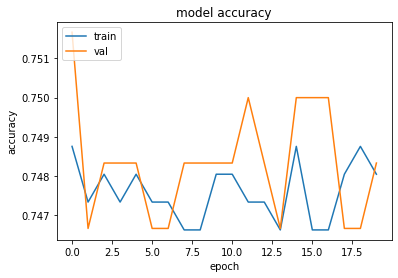

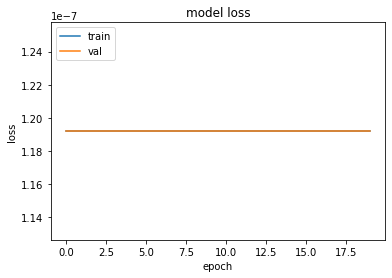

In [13]:
def plot_results(history):
    # summarize history for accuracy
    plt.plot(history['categorical_accuracy'])
    plt.plot(history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

# If already trained load the history, else use the one created on train
if IS_ALREADY_TRAINED:
    history = pd.read_csv(TRAINING_LOGS_FILE, sep=',', engine='python')

plot_results(history)

## Classification examples

[[0.51204294]]


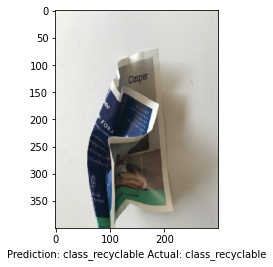

[[0.5074678]]


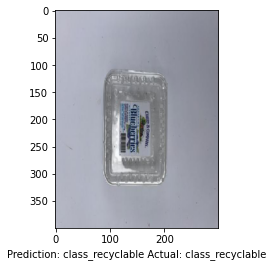

[[0.50618404]]


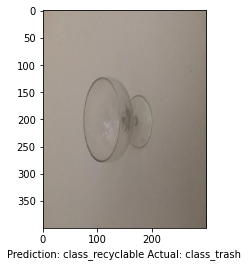

[[0.5100802]]


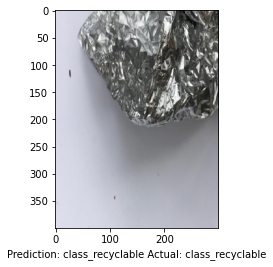

[[0.50842005]]


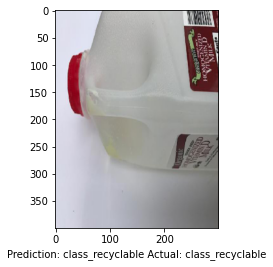

[[0.50859]]


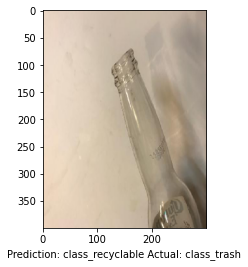

[[0.509231]]


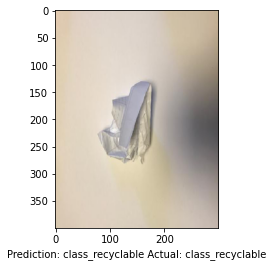

[[0.5113776]]


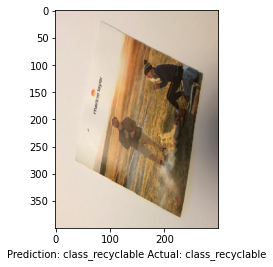

[[0.50631934]]


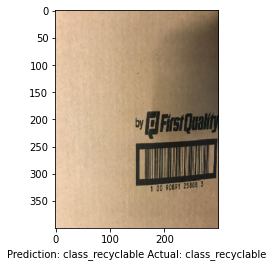

[[0.51164806]]


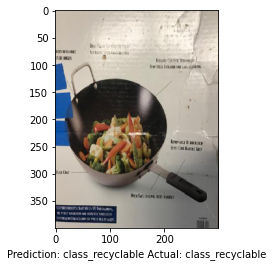

[[0.51213425]]


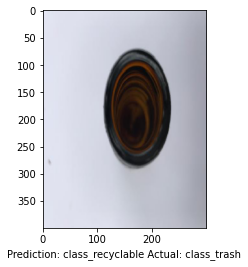

[[0.5104104]]


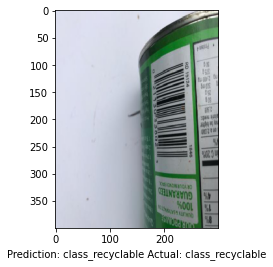

[[0.5113681]]


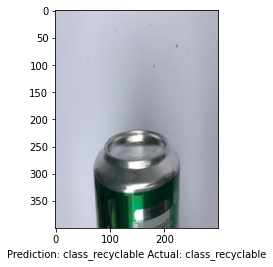

[[0.5052682]]


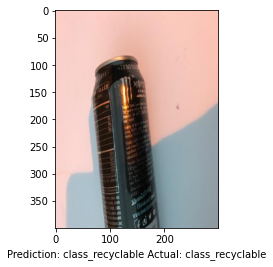

[[0.50816447]]


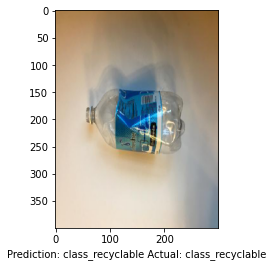

[[0.51010346]]


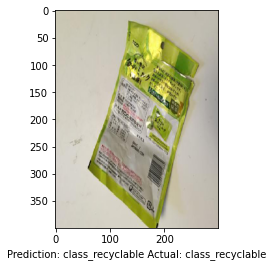

[[0.5069187]]


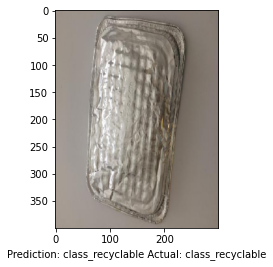

[[0.5095844]]


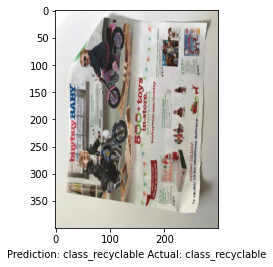

[[0.51008344]]


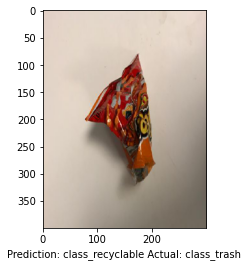

[[0.50704587]]


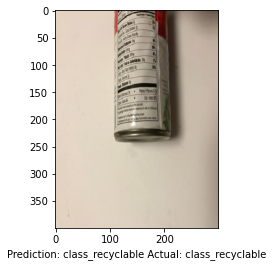

In [14]:
test_generator.reset()
labels = ['class_recyclable', 'class_trash']

for i in range(0,20):
  x,y = test_generator.next()
  image = x[0]
  plt.imshow(image)
  y_prob = model.predict(x)
  print(y_prob)
  y_classes = y_prob.argmax(axis=-1)
  plt.xlabel("Prediction: " + labels[y_classes[0]] + " Actual: " + labels[y.argmax(axis=-1)[0]])
  plt.show()